# Energy Consumption Prediction with NGBoost

This Notebook aims to train an NGBoost Model for the same Energy Consumption Prediction Problem [I have attempted in this Notebook with LightGBM](https://www.kaggle.com/hgultekin/predicting-energy-consumption-of-turkey-lightgbm). Before going further into the code, please familiarize yourself with this novel boosting algorithm, which makes probabilistic predictions with Gradient Boosting, through below references. There are these great sources detailing the Natural Gradient Boosting (NGBoost) including [the official research paper](https://arxiv.org/abs/1910.03225) and the [towardsthedatascience article](https://towardsdatascience.com/interpreting-the-probabilistic-predictions-from-ngboost-868d6f3770b2) by one of the authors (Alejandro Schuler), therefore I will not repeat the process here in this notebook:

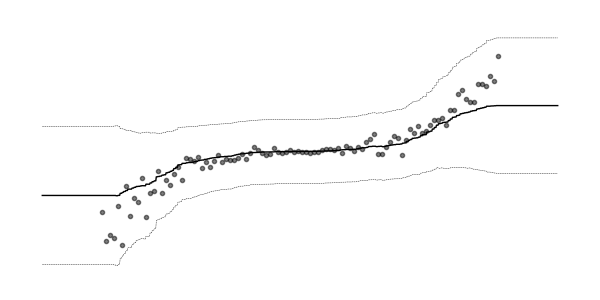


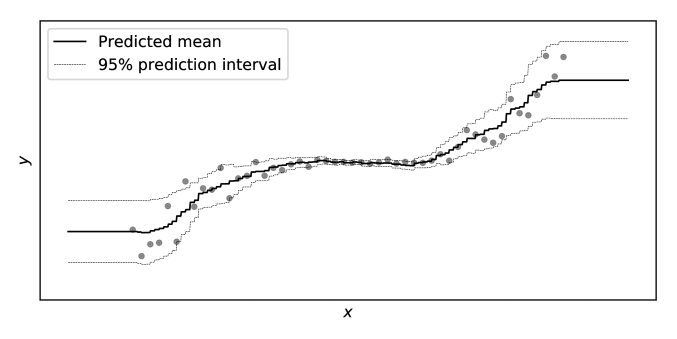

**References**:

* https://stanfordmlgroup.github.io/projects/ngboost/
* https://github.com/stanfordmlgroup/ngboost
* https://arxiv.org/abs/1910.03225
* https://towardsdatascience.com/interpreting-the-probabilistic-predictions-from-ngboost-868d6f3770b2
* https://towardsdatascience.com/ngboost-explained-comparison-to-lightgbm-and-xgboost-fda510903e53


In [ ]:
!pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('darkgrid')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df_train = pd.read_csv('../input/predicting-energy-consumption-of-turkey-lightgbm/energy_cons_train.csv', parse_dates = ['Date'])
df_test = pd.read_csv('../input/predicting-energy-consumption-of-turkey-lightgbm/energy_cons_test.csv', parse_dates = ['Date'])

In [ ]:
df_train.info()

In [ ]:
df_test.info()

In [ ]:
df_train.head()

In [ ]:
df_train[['Consumption (MWh)']].describe()

In [ ]:
df_train[df_train['Consumption (MWh)'] == 0] # I received an overflow error while training the model, I suspected some zeros may be the reason, yes found it!

In [ ]:
#df_train = df_train.loc['2016-03-28':, :].reset_index()

In [ ]:
df_test[['Consumption (MWh)']].describe()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train.Date, y=np.expm1(df_train['Consumption (MWh)']),
                    mode='markers',
                    name='TRAIN SET'))
fig.add_trace(go.Scatter(x=df_test.Date, y=np.expm1(df_test['Consumption (MWh)']),
                    mode='markers',
                    name='TEST SET'))
fig.show()

In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [ ]:
print(df_train.shape, df_test.shape) 

In [ ]:
y_train = df_train['Consumption (MWh)'].values
X_train = df_train.drop(['Date','Consumption (MWh)'], axis=1).values

y_test = df_test['Consumption (MWh)'].values
X_test = df_test.drop(['Date','Consumption (MWh)'], axis=1).values

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from ngboost import NGBRegressor
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE

In [ ]:
model_ngb = NGBRegressor(n_estimators=650,  natural_gradient=True, learning_rate = 0.01,Base=default_tree_learner, Dist=Normal, Score=MLE, verbose_eval =50)
model_ngb.fit(X_train, y_train, X_val = X_test, Y_val = y_test, early_stopping_rounds = 10)

In [ ]:
y_train_ngb = model_ngb.pred_dist(X_train)
print("Train set RMSE (Log): " + str(np.sqrt(mean_squared_error(y_train_ngb.loc, y_train))))
print("Train set MAPE (Log): " + str(mean_absolute_percentage_error(y_train, y_train_ngb.loc)))
print("Train set RMSE (Non-Log): " + str(np.sqrt(mean_squared_error(np.expm1(y_train_ngb.loc), np.expm1(y_train)))))
print("Train set MAPE (Non-Log): " + str(mean_absolute_percentage_error(np.expm1(y_train), np.expm1(y_train_ngb.loc))))

In [ ]:
y_test_ngb= model_ngb.pred_dist(X_test)
print("Validation set RMSE (Log): " + str(np.sqrt(mean_squared_error(y_test_ngb.loc, y_test))))
print("Validation set MAPE (Log): " + str(mean_absolute_percentage_error(y_test, y_test_ngb.loc)))
print("Validation set RMSE (Non-Log): " + str(np.sqrt(mean_squared_error(np.expm1(y_test_ngb.loc), np.expm1(y_test)))))
print("Validation set MAPE (Non-Log): " + str(mean_absolute_percentage_error(np.expm1(y_test), np.expm1(y_test_ngb.loc))))

In [ ]:
predictions = pd.DataFrame(y_test_ngb.loc, columns=['Predictions'])
predictions_upper = pd.DataFrame(y_test_ngb.dist.interval(0.95)[1], columns=['Predictions_upper'])
predictions_lower = pd.DataFrame(y_test_ngb.dist.interval(0.95)[0], columns=['Predictions_lower'])

In [ ]:
df_figure = pd.concat([df_test[['Date', 'Consumption (MWh)']], predictions, predictions_lower, predictions_upper], axis=1)
df_figure

In [ ]:
df_figure.isna().sum()

In [ ]:
df_figure[['Consumption (MWh)','Predictions', 'Predictions_lower', 'Predictions_upper']] = np.expm1(df_figure[['Consumption (MWh)','Predictions', 'Predictions_lower', 'Predictions_upper']])

In [ ]:
df_figure

In [ ]:
def plot_results(df, title):
    fig, ax = plt.subplots(figsize=(22, 5))
    plt.plot(df.Date, df.Predictions, label = 'Consumption_Predicted', color='b', lw=2)
    plt.fill_between(df.Date, df.Predictions_lower,  df.Predictions_upper,label = '95% Prediction Interval', color='gray', alpha=0.5)
    plt.scatter(df.Date, df['Consumption (MWh)'], label = 'Consumption (MWh) Actual', color='g', lw=3)
    ax.legend(fontsize = 14)
    plt.title('Hourly Power Consumption Actual vs. Predicted Values with Prediction Intervals')
    plt.xlabel(title)
    plt.show()

## First Week Predictions:

In [ ]:
print(df_test.Date.min(), df_test.Date.max())

In [ ]:
df_figure_fw = df_figure.set_index('Date').loc['2020-01-01 00:00:00':'2020-01-08 00:00:00', :].reset_index()
df_figure_fw

In [ ]:
plot_results(df_figure_fw, 'First Week in Test Set')

## First Month Predictions:

In [ ]:
df_figure_fm = df_figure.set_index('Date').loc['2020-01-01 00:00:00':'2020-02-15 00:00:00', :].reset_index()
df_figure_fm

In [ ]:
plot_results(df_figure_fm, 'First Month in Test Set')

## Last Month Predictions

In [ ]:
df_figure_lm = df_figure.set_index('Date').loc['2020-02-15 00:00:00':'2020-03-14 23:00:00', :].reset_index()
df_figure_lm

In [ ]:
plot_results(df_figure_lm, 'First Month in Test Set')

## Or with my favorite visualization tool :)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_figure.Date, y=df_figure.Predictions,
    fill=None,
    mode='lines',
    line_color='blue',
    name='Predictions'
    ))
fig.add_trace(go.Scatter(x=df_figure.Date, y=df_figure.Predictions_lower,
    fill=None,
    mode='lines',
    line_color='gray',
    name='Predictions_Lower',
    ))
fig.add_trace(go.Scatter(
    x=df_figure.Date, y=df_figure.Predictions_upper,
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='gray',name='Predictions_Upper'
    ))
fig.add_trace(go.Scatter(x=df_figure.Date, y=df_figure['Consumption (MWh)'],
    fill=None,
    mode='markers',
    line_color='green',
    name='Actual Consumption'
    ))

fig.show()

**Final Thoughts**: NGboost seems to give more accurate results for this particular problem w.r.t. the LightGBM, along with an additional flexibility of easily generating the prediction intervals along with the predictions. Based on my multiple observations of comparing the two boosting algorithms, I can say that the fact that the LightGBM faster and NGboost is slightly more accurate (for similar hyperparameters) usually holds true.